## Mini syrinx model 

For the dual pathway model, we would like to test it using a syrinx-based performance contour.
For this, we attempt to generate a performance landscape using a syrinx model used by Darshan, Amador, etc.
https://doi.org/10.1038/nature11967

Here, we provide two vectors, pressure and tension, as input.
The model comprises two ODEs, which produces the labial position x(t) and velocity y(t).

We transform this to generate song, and see the frequency distribution.

In [1]:
#Libraries

import numpy as np
import matplotlib.pyplot as plt         
import queue
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram

In [2]:
np.random.seed(100)

In [3]:
# Parameters
gamma = 12000 
duration = 0.050 #s
dt = 1/44100 #s  #* 0.1 #1.e-4
Amp = 4

# Trachea parameters
r=-0.9
v=350*100
L=1.9
tau_0=2*L/v # Propagation time along trachea
tau_n=int(tau_0/dt)

In [4]:
# Track position and velocity 
nt = int(duration/dt)
X = np.zeros(nt)          # Labial position
Y = np.zeros(nt)          # Velocity

#### Building the tension and pressure vectors for input


In [5]:
def sigmoid(x):
      return 1 / (1 + np.exp(-x))

In [6]:
# RC4
def Tension(t):
    """ Generalised exponential waveform """
    return   .3 - .2*np.exp(-200*t) -.00001 * np.exp(200*t) 

    
def Pressure(t):
    """ Constant """
    return 0.04*np.sin((duration/2 + t)*np.pi*10) + 0.05

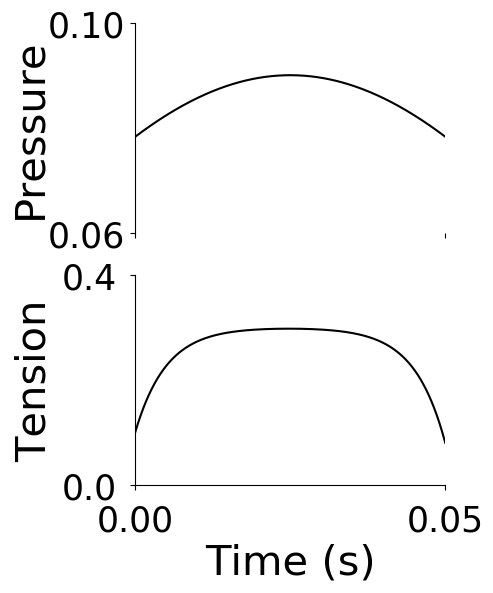

In [7]:
# Plots input signals to syrinx

figure, ax = plt.subplots(2, sharex=True)

time_x = np.linspace(0, duration, nt)
ax[0].plot(time_x, Pressure(time_x), color='black')

time_x = np.linspace(0, duration, nt)
ax[1].plot(time_x, Tension(time_x), color='black')

ax[0].set_ylabel('Pressure', fontsize=30)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_ylim(0.06,.10)
ax[0].set_xlim(0,.05)
ax[0].set_xticks([])
ax[0].set_yticks([.06,.10])
ax[0].tick_params(labelsize=25)
ax[0].yaxis.set_label_coords(-0.275,.5)

ax[1].set_ylabel('Tension', fontsize=30)
ax[1].set_xlabel('Time (s)', fontsize=30)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_ylim(0,.4)
ax[0].set_xlim(0,.05)
ax[0].set_xticks([0, .05])
ax[1].set_yticks([0,.4])
ax[1].tick_params(labelsize=25, pad=10)
ax[1].yaxis.set_label_coords(-0.26,.5)

figure.set_size_inches(4, 6, forward=True)

# plt.savefig('Figures/Fig2-SyrinxInput.pdf', bbox_inches='tight')

In [8]:
def syrinxODE(t, y):
    ''' ODEs used in Amador paper'''
    
    y0, y1 = y
    dydt = [y1,
         -Pressure(t)*(gamma**2) - Tension(t)*(gamma**2)*y0 - (gamma**2)*(y0**3) - gamma*(y0**2)*y1 + (gamma**2)*(y0**2) - gamma*y0*y1
           ]
    return dydt

In [9]:
solution = solve_ivp(syrinxODE, [0, duration], [1, 1], method = "RK45", t_eval = np.linspace(0,duration,nt), rtol = 1e-8, atol = 1e-8)

In [10]:
# Extract labial position (X) and velocity (Y)
X = solution['y'][0]
Y = solution['y'][1]

In [11]:
# Transform into song
time_x = np.linspace(0, duration, nt)
song = Amp * Pressure(time_x) * Y

In [12]:
## Trachea from Darshan, et. al. https://doi.org/10.1038/ncomms15415

# Input to trachea = output of syrinx
y0 = song.T

# To generate pressure output from trachea
P_i=np.zeros((len(y0)))

# See Fig 1 in Amador paper. Round-about way to implement that.
Buffer = queue.Queue()
for i in np.arange(tau_n):
    Buffer.put(np.random.random())

for i in np.arange(len(y0)):
    P_i[i] = y0[i] - r*Buffer.get();      
    # update_buffer
    Buffer.put(P_i[i])

# P_tr from P_in (ref Amador paper)
BufferB=np.zeros((tau_n))
P_tmp= np.concatenate((BufferB, P_i))
P_t=(1-r)*P_tmp[:-tau_n]


In [13]:
# Plots

In [14]:
time_x = np.linspace(0, duration, nt)

Text(0.5, 0, 'Time (s)')

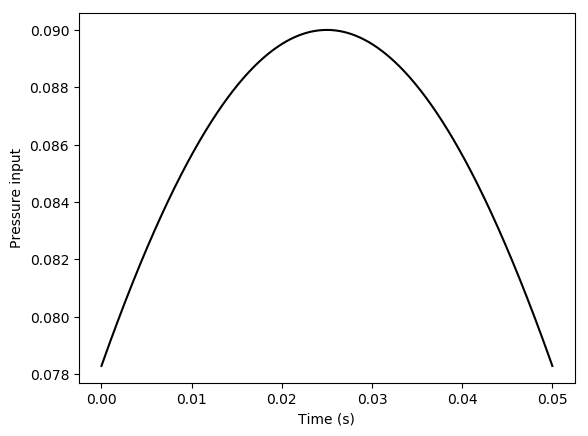

In [15]:
plt.plot(time_x, Pressure(time_x), color='black')

plt.ylabel('Pressure input')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

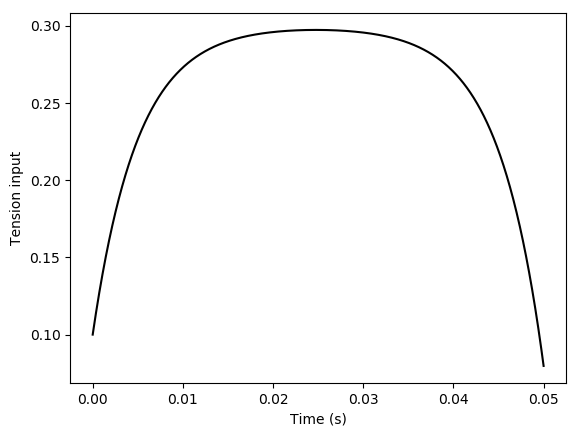

In [16]:
plt.plot(time_x, Tension(time_x), color='black')
plt.ylabel('Tension input')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

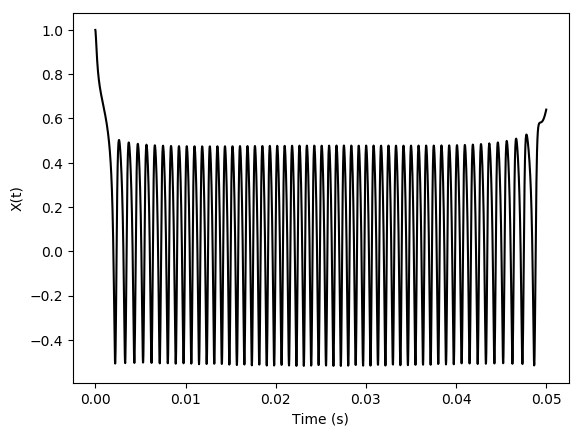

In [17]:
plt.plot(time_x, X, color='black')
plt.ylabel('X(t)')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

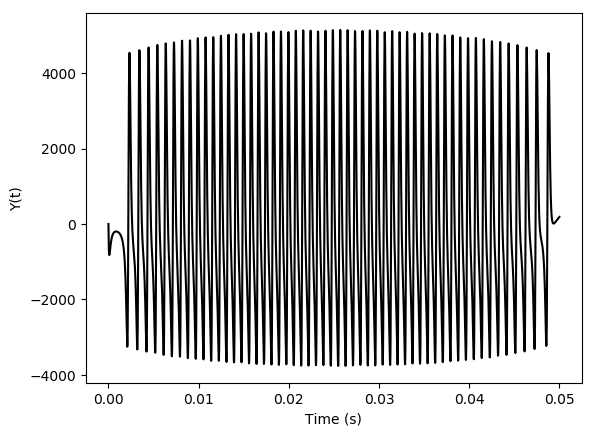

In [18]:
plt.plot(time_x, Y, color='black')
plt.ylabel('Y(t)')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

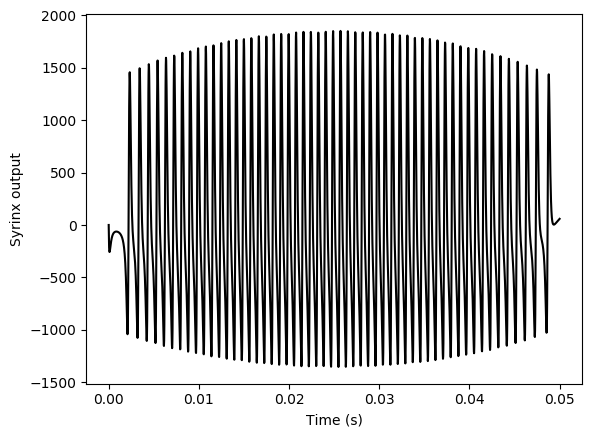

In [19]:
plt.plot(time_x, song, color='black')
plt.ylabel('Syrinx output')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

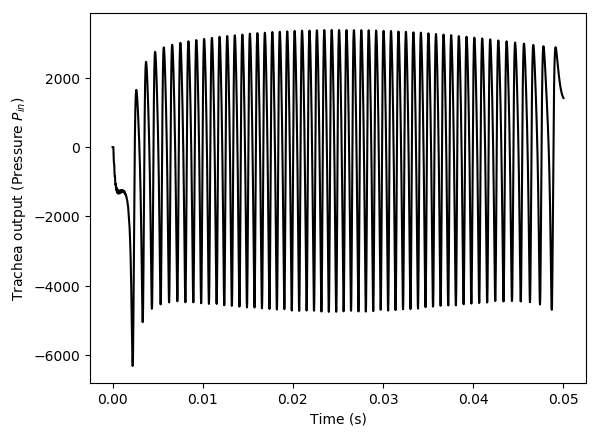

In [20]:
plt.plot(time_x, P_t, color='black')
plt.ylabel('Trachea output (Pressure $P_{in}$)')
plt.xlabel('Time (s)')

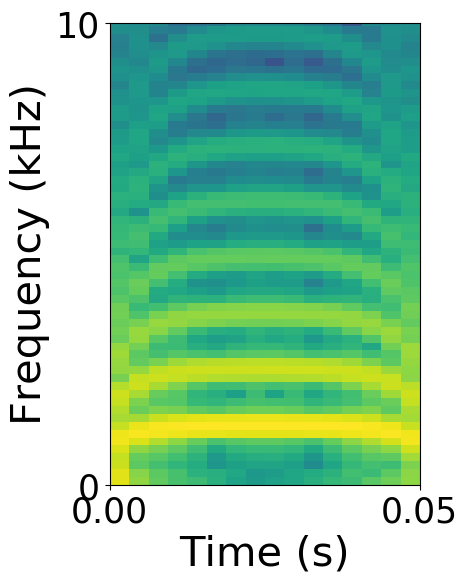

In [21]:
# Plots spectrogram of syrinx output

figure, ax = plt.subplots(1)

(spectrumP, freqsP, t, im) = plt.specgram(P_t, Fs=1/dt, NFFT=256, noverlap=128, xextent=[0,.05], cmap='viridis')
im


ax.set_ylabel('Frequency (kHz)', fontsize=30)
ax.set_xlabel('Time (s)', fontsize=30)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_ylim(0,10000)
ax.set_xlim(0,.05)
ax.set_xticks([0,.05])
ax.set_yticks([0, 10000])
ax.set_yticklabels([0, 10])
ax.tick_params(labelsize=25)

figure.set_size_inches(4, 6, forward=True)


# plt.savefig('Figures/Fig2-SyrinxOutputSpec.pdf', bbox_inches='tight')

Text(0.5, 0, 'Frequency')

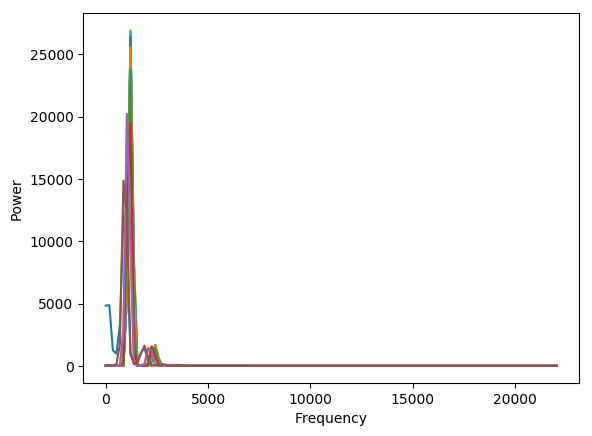

In [22]:
(freqs, t, spectrum) = spectrogram(P_t, fs=1/dt)
plt.plot(freqsP, spectrumP)
plt.ylabel('Power')
plt.xlabel('Frequency')

/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Power')

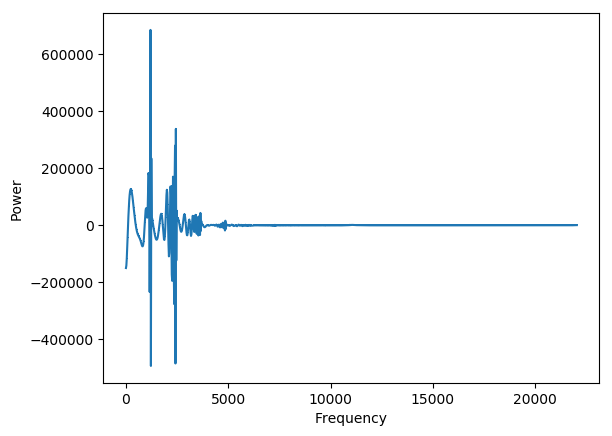

In [23]:
sp = np.fft.rfft(P_t)
freqs_sp = np.arange(sp.size) / (dt * nt)
plt.plot(freqs_sp, sp, marker=',')
plt.xlabel('Frequency')
plt.ylabel('Power')